In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This file is used to **Pre-process the dataset before the model training.**


---


Here the dataset (videos extracted frames) path is given, which is then further used to visualize the dataset and for extraction of the facial region from each 
frame.


---


The detail of the working of each cell is described above it.

In [ ]:
import matplotlib.pyplot as plt #plotting library
import os #OS module to do os level operation such as mkdir,listsdir,..
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np # To handle matrix operations
import cv2 # computer vision library
import dlib # Automatic face tracking library
face_detector = dlib.get_frontal_face_detector() # instantiating face detector class from dlib library 
from keras.applications.xception import preprocess_input # to preprocess the input
import joblib # To presist the intermideate files 
import warnings
warnings.filterwarnings('ignore')# To ignore the unwanted warning messages

Give the address of the dataset directories containing frames from the videos.


In [ ]:

DATASET_PATHS = {
    'original': '/content/drive/MyDrive/Hashim/Final Submission Code With readme file/Dataset Raw (Video and Frames) /Original',
    'Deepfakes': '/content/drive/MyDrive/Hashim/Final Submission Code With readme file/Dataset Raw (Video and Frames) /DeepFakes',
    'Face2Face': '/content/drive/MyDrive/Hashim/Final Submission Code With readme file/Dataset Raw (Video and Frames) /Face2Face',
    'FaceSwap': '/content/drive/MyDrive/Hashim/Final Submission Code With readme file/Dataset Raw (Video and Frames) /FaceSwap'
}

This cell is used to visualize the images from different directories.
This cell only takes the first image from the first subfolder in the corresponding directory. Convert image to RGB and store them as an image array and shows them in next cell.

In [ ]:
images = []
for path in DATASET_PATHS:
    for seq in os.listdir(DATASET_PATHS[path]+'/Images/')[:1]:
        for image in os.listdir(DATASET_PATHS[path]+'/Images/'+seq)[:1]:
            img = cv2.imread(DATASET_PATHS[path]+'/Images/'+seq+'/'+image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append([img,path])
            print (images)

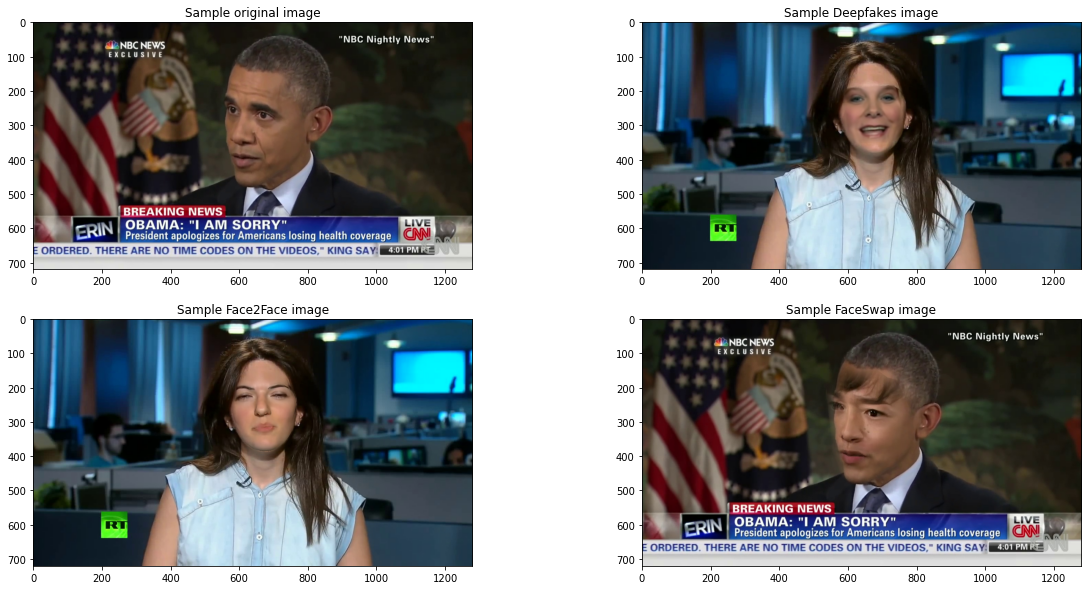

In [ ]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Sample {} image".format(images[i][1]))
    plt.imshow(images[i][0])
    #print(images[i])

This function is taken from (https://github.com/ondyari/FaceForensics/tree/master/classification). 

It Expects a dlib face to generate a quadratic bounding box.
* param face: dlib face class
* param width: frame width
* param height: frame height
* param scale: bounding box size multiplier to get a bigger face region
* param minsize: set minimum bounding box size
* return: x, y, bounding_box_size in opencv form

In [ ]:
def get_boundingbox(face, width, height, scale=1.3, minsize=None):

    x1 = face.left() # Taking lines numbers around face
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale) # scaling size of box
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

Here we can visualize the cropped face from the frames.

* This cell takes an image from the previous cell as an input.

* Crop the face from the image using the frontal face detector by upscaling of 1.

* Use the bounding box to create a new frame according to the dimensions of the image.

* Show the cropped face in the next cell.



In [ ]:
cropped_image =[]
for image in images:
    faces = face_detector(image[0], 1) #upsample the image 1 time.  This will make everything bigger and allow us to detect more
    # faces.
    height, width = image[0].shape[:-1]#take dimensions leaving the color channel
    try: # If in case face is not detected at any frame 
        x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
    except IndexError:
        continue
    cropped_image.append([image[0][y:y+size, x:x+size],image[1]])#save the cropped face in array


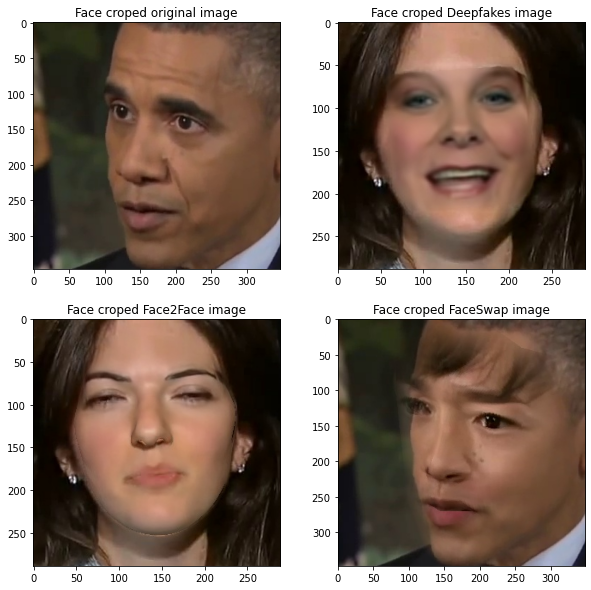

In [ ]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Face croped {} image".format(cropped_image[i][1]))
    plt.imshow(cropped_image[i][0])

Split of the dataset in to train, test and cv.

In [ ]:
#Take the frames from first 40 folders and list them as training dataset
train_original = (os.listdir(DATASET_PATHS['original']+'/Images/'))[:40]
train_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/Images/'))[:40]
train_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/Images/'))[:40]
train_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/Images/'))[:40]
train = [train_original,train_Deepfakes,train_FaceSwap,train_Face2Face]#Creats a list of training dataset
types = ['Orignal','DeepFakes','FaceSwap','Face2Face']

In [ ]:
print (len(train_original),len(train_Deepfakes),len(train_FaceSwap),len(train_Face2Face)
       )

40 40 40 40


In [ ]:
#Take the frames from first folder 40 to 50 and list them as cv dataset
cv_original =  (os.listdir(DATASET_PATHS['original']+'/Images/'))[40:50]
cv_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/Images/'))[40:50]
cv_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/Images/'))[40:50]
cv_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/Images/'))[40:50]
cv = [cv_original,cv_Deepfakes,cv_FaceSwap,cv_Face2Face]#Creat list of CV dataset
types = ['Orignal','DeepFakes','FaceSwap','Face2Face']

In [ ]:
print(len(cv_original),len(cv_Deepfakes),len(cv_FaceSwap),len(cv_Face2Face))

10 10 10 10


In [ ]:
#Take the frames from reamining folders and list them as test dataset
test_original = (os.listdir(DATASET_PATHS['original']+'/Images/'))[-13:-1]
test_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/Images/'))[-13:-1]
test_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/Images/'))[-15:-1]
test_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/Images/'))[-13:-1]
test = [test_original,test_Deepfakes,test_FaceSwap,test_Face2Face]#Creat a list of test dataset
types = ['Orignal','DeepFakes','FaceSwap','Face2Face']

In [ ]:
print (len(test_original),len(test_Deepfakes),len(test_FaceSwap),len(test_Face2Face))

12 12 14 12


**This function expects a split list (train, test, and cv) generated in the previous cell. and crop the faces from the split category's images and store them in corresponding split type(train, test,cv).**

In [ ]:
def track_face(split_type,Split,output_mkdir=True):
    """
    inputs:     1- split_type: list video's frame names for train/test/CV
                2- Split: train/test/cv in str format
    
    processing: extract the faces from the frames and store them in their corresponding test, train and CV directories

    output:     train, test and CV directories along with the cropped faces  
    """
    
    for part in zip(split_type,types):
        for video in tqdm(part[0]):
            if output_mkdir==True:
                #patht to creat the directory
                os.makedirs('/content/drive/MyDrive/Hashim/Final/'+Split+'/'+part[1]+'/'+video, exist_ok=True)#if not exist creat a new output directory
            input_path = DATASET_PATHS[part[1]]+'/Images/'+video
            #output dir path
            output_path = '/content/drive/MyDrive/Hashim/Final/'+Split+'/'+part[1]+'/'+video#output directory
            images = os.listdir(input_path)
            images.sort(key=lambda x: os.path.getmtime(input_path+'/'+x))
            for img in images[10:111]: #We only take 101 frames of the videos to ease commputation
                image = cv2.imread(input_path+'/'+img)
                faces = face_detector(image, 1)
                height, width = image.shape[:2]
                try: # If in case face is not detected at any frame 
                    x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
                except IndexError:
                    continue
                cropped_face = image[y:y+size, x:x+size]
                cv2.imwrite(output_path+'/'+img,cropped_face)

In [ ]:
track_face(split_type=train,Split='train')

In [ ]:
track_face(split_type=test,Split='test')

In [ ]:
track_face(split_type=cv,Split='cv')

# **From here, the labeling part of the dataset starts.**

In this cell, we take all the files from the train, test, and cv directories, shuffle them, and then add a postfix (-Orignal, -Face2Face, -DeepFakes, and -Faceswap) at their end, which will help to label them in next cells.

In [ ]:

#Created to shuffle the videos
train_list=[]
for ind,i in enumerate(train):
    for j in i:
        train_list.append(j+'-'+types[ind])#add the postfix at end of each image to indicate the class it belong to

test_list=[]
for ind,i in enumerate(test):
    for j in i:
        test_list.append(j+'-'+types[ind])

cv_list=[]
for ind,i in enumerate(cv):
    for j in i:
        cv_list.append(j+'-'+types[ind])


In [ ]:
print (train_list)

['134-Orignal', '147-Orignal', '159-Orignal', '150-Orignal', '153-Orignal', '145-Orignal', '130-Orignal', '139-Orignal', '144-Orignal', '155-Orignal', '160-Orignal', '158-Orignal', '149-Orignal', '152-Orignal', '136-Orignal', '154-Orignal', '141-Orignal', '133-Orignal', '148-Orignal', '135-Orignal', '128-Orignal', '117-Orignal', '124-Orignal', '121-Orignal', '114-Orignal', '123-Orignal', '122-Orignal', '115-Orignal', '119-Orignal', '113-Orignal', '102-Orignal', '112-Orignal', '101-Orignal', '107-Orignal', '103-Orignal', '110-Orignal', '109-Orignal', '105-Orignal', '100-Orignal', '106-Orignal', '585_599-DeepFakes', '599_585-DeepFakes', '481_469-DeepFakes', '607_683-DeepFakes', '529_633-DeepFakes', '554_572-DeepFakes', '572_554-DeepFakes', '522_337-DeepFakes', '556_588-DeepFakes', '588_556-DeepFakes', '565_589-DeepFakes', '589_565-DeepFakes', '488_399-DeepFakes', '520_542-DeepFakes', '542_520-DeepFakes', '550_452-DeepFakes', '598_178-DeepFakes', '596_609-DeepFakes', '609_596-DeepFakes', 

Path of test, train and cv directory created by 

```
def track_face 
```
 function earlier.



In [ ]:

TEST_DATADIR = '/content/drive/MyDrive/Hashim/Final Submission Code With readme file/Xception Net/test'
TRAIN_DATADIR = '/content/drive/MyDrive/Hashim/Final Submission Code With readme file/Xception Net/train'
CV_DATADIR = '/content/drive/MyDrive/Hashim/Final Submission Code With readme file/Xception Net/cv' 

This function takes the data directory and shuffle list as input and labels them accordingly.

* All the images from test, train, and cv, with a postfix of '-Orignal' (real images), are labeled 0 by this function.

* All the images from test, train, and cv, with a postfix other than '-Orignal' (fake images), are labeled 1 by this function.

The images are converted to a size of 299x299 and RGB color. 

Afterward, the images are pickel stored as an array along with their corresponding labels.
 

In [ ]:
def create_data(DATADIR,shuffled_list):
    '''
    inputs :    1- path of the data directory (test, train and  Cv)
                2- the shuffel list created earlier contain the names and lables of the images in the corresponding directory
    
    processing: based on the postfix assigned to the images earlier label all the images with post fix of '-Orignal' as 0 and label all other as '1'

    output :    1- X the array of the images
                2- y the actual lables (1 or 0) of the images 
    '''
    data = []
    for name in shuffled_list: 
        i = 0
        label = name.split('-')[-1] 
        class_num = 0
        folder_name = name.split('-')[0]
        #print (folder_name)
        if label =='Orignal': 
            class_num=0
            folder_name = name.split('-')[0]
            files = os.listdir(DATADIR+'/'+label+'/'+folder_name)
            path = DATADIR+'/'+label+'/'+folder_name 
            for img in tqdm(files):           
              try:
                  #print("Path and Image for Orignal", path,"/",img)
                  img_array = cv2.imread(os.path.join(path,img))
                  #cv2_imshow(img_array)
                  img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                  new_array = cv2.resize(img_array, (299, 299))
                  #print (class_num)
                  i += 1
                  data.append([new_array, class_num])  
              except Exception as e:
                  print(str(e))
        
        else:
            class_num = 1
            folder_name = name.split('-')[0]
            files = os.listdir(DATADIR+'/'+label+'/'+folder_name)
            path = DATADIR+'/'+label+'/'+folder_name    
            for img in tqdm(files):           
              try:
                  #print("Path and Image for Fake", path,img)
                  img_array = cv2.imread(os.path.join(path,img))
                  img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                  new_array = cv2.resize(img_array, (299, 299))
                  #print (class_num)
                  i += 1
                  data.append([new_array, class_num])
              except Exception as e:
                  print(str(e))            
    print("Data gathering completed......\n Separating features and class lables")
    x = [] # Image array
    y = [] # Actual Labels
    for row in tqdm(data):
        x.append(row[0])
        y.append(row[1])
    X = np.array(x).reshape(-1, 299, 299, 3)
    print("XXXXXXXXXX",X, "YYYYYYYYYY",y)
    print("Done")

    return X,y #X--> Image array. y--> labels

In [ ]:
np.random.shuffle(train_list)
X_train,Y_train = create_data(DATADIR=TRAIN_DATADIR,
                        
                        shuffled_list=train_list)

In [ ]:
print(Y_train)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
X_train = preprocess_input(X_train)

In [ ]:
joblib.dump(X_train, '/content/drive/MyDrive/Hashim/Final/x_train.pkl')
joblib.dump(Y_train, '/content/drive/MyDrive/Hashim/Final/y_train.pkl')

['/content/drive/MyDrive/Hashim/Final/y_train.pkl']

In [ ]:
np.random.shuffle(test_list)
X_test,Y_test = create_data(DATADIR=TEST_DATADIR,
                        
                        shuffled_list=test_list)

In [ ]:
X_test = preprocess_input(X_test)

In [ ]:
joblib.dump(X_test, '/content/drive/MyDrive/Hashim/Final/x_test.pkl')
joblib.dump(Y_test, '/content/drive/MyDrive/Hashim/Final/y_test.pkl')

['/content/drive/MyDrive/Hashim/Final/y_test.pkl']

In [ ]:
np.random.shuffle(cv_list)
X_cv,Y_cv = create_data(DATADIR=CV_DATADIR,
                        
                        shuffled_list=cv_)

In [ ]:
X_cv = preprocess_input(X_cv)

In [ ]:
joblib.dump(X_test, '/content/drive/MyDrive/Hashim/Final/x_cv.pkl')
joblib.dump(Y_test, '/content/drive/MyDrive/Hashim/Final/y_cv.pkl')